# Performs RFM (Recency, Frequency, Monetary) Customer Segmentation using K-Means with Snowpark, based on an online retail dataset from Kaggle

In [24]:
%config Completer.use_jedi = False
from snowflake.snowpark.session import Session
from snowflake.snowpark import DataFrame, Window
from snowflake.snowpark.types import *
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import col, lit

# Snowflake connection info is saved in config.py
from config import snowflake_conn_prop


## Configure Snowpark Session and initialize the database, warehouse, and schema

In [25]:
session = Session.builder.configs(snowflake_conn_prop).create()
session.sql("use role {}".format(snowflake_conn_prop['role'])).collect()
session.sql("use database {}".format(snowflake_conn_prop['database'])).collect()
session.sql("use schema {}".format(snowflake_conn_prop['schema'])).collect()
session.sql("use warehouse {}".format(snowflake_conn_prop['warehouse']))
print(session.sql('select current_warehouse(), current_database(), current_schema(), current_user()').collect())


[Row(CURRENT_WAREHOUSE()='COMPUTE_WH', CURRENT_DATABASE()='RETAIL', CURRENT_SCHEMA()='PUBLIC', CURRENT_USER()='ADMIN')]


## Read a table as Snowpark dataframe

In [26]:
df = session.table("RETAIL")
df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------
|"INVOICENO"  |"STOCKCODE"  |"DESCRIPTION"                        |"QUANTITY"  |"INVOICEDATE"        |"UNITPRICE"  |"CUSTOMERID"  |"COUNTRY"       |
----------------------------------------------------------------------------------------------------------------------------------------------------
|536365       |85123A       |WHITE HANGING HEART T-LIGHT HOLDER   |6           |2010-12-01 08:26:00  |2.55         |17850         |United Kingdom  |
|536365       |71053        |WHITE METAL LANTERN                  |6           |2010-12-01 08:26:00  |3.39         |17850         |United Kingdom  |
|536365       |84406B       |CREAM CUPID HEARTS COAT HANGER       |8           |2010-12-01 08:26:00  |2.75         |17850         |United Kingdom  |
|536365       |84029G       |KNITTED UNION FLAG HOT WATER BOTTLE  |6           |2010-12-01 08:26:00  |3.39

## Exploratory Data Analysis

In [27]:
df.describe().show()

---------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"INVOICENO"  |"STOCKCODE"  |"DESCRIPTION"                   |"QUANTITY"  |"UNITPRICE"        |"CUSTOMERID"       |"COUNTRY"    |
---------------------------------------------------------------------------------------------------------------------------------------------
|count      |541909       |541909       |540455                          |541909      |541909.0           |406829.0           |541909       |
|mean       |NULL         |NULL         |NULL                            |NULL        |4.61111362         |15287.69057        |NULL         |
|stddev     |NULL         |NULL         |NULL                            |NULL        |96.75985306153116  |1713.600303321635  |NULL         |
|min        |536365       |10002        | 4 PURPLE FLOCK DINNER CANDLES  |-1          |-11062.06          |12346.0            |Australia    |
|max  

### Remove null values and invalid data

In [28]:
df = df.dropna()
df = df.filter("QUANTITY > 0 and UNITPRICE > 0")
df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------
|"INVOICENO"  |"STOCKCODE"  |"DESCRIPTION"                        |"QUANTITY"  |"INVOICEDATE"        |"UNITPRICE"  |"CUSTOMERID"  |"COUNTRY"       |
----------------------------------------------------------------------------------------------------------------------------------------------------
|536365       |85123A       |WHITE HANGING HEART T-LIGHT HOLDER   |6           |2010-12-01 08:26:00  |2.55         |17850         |United Kingdom  |
|536365       |71053        |WHITE METAL LANTERN                  |6           |2010-12-01 08:26:00  |3.39         |17850         |United Kingdom  |
|536365       |84406B       |CREAM CUPID HEARTS COAT HANGER       |8           |2010-12-01 08:26:00  |2.75         |17850         |United Kingdom  |
|536365       |84029G       |KNITTED UNION FLAG HOT WATER BOTTLE  |6           |2010-12-01 08:26:00  |3.39

In [29]:
df.group_by("COUNTRY").count().show()

----------------------------
|"COUNTRY"       |"COUNT"  |
----------------------------
|United Kingdom  |354317   |
|France          |8341     |
|Australia       |1182     |
|Germany         |9040     |
|Norway          |1071     |
|EIRE            |7236     |
|Switzerland     |1841     |
|Spain           |2484     |
|Portugal        |1462     |
|Italy           |758      |
----------------------------



### Filter to United Kingdom, rest of the data might have weaker representation from the population

In [30]:
df = df.filter("COUNTRY = 'United Kingdom'")

## Features Preparation

### Obtain the recency, frequency and monetary (RFM) features for segmentation

In [31]:
import datetime

df = df.with_column("NOW",lit(datetime.datetime(2012,1,1)))

df.group_by("CUSTOMERID").max("INVOICENO")

#RECENCY, FREQUENCY, MONETARY
df_tf = df.group_by("CUSTOMERID")\
          .agg(F.max("INVOICEDATE"),\
               F.max("NOW"),\
               F.sum(col("QUANTITY")*col("UNITPRICE")).alias("Monetary"),\
               F.count("INVOICENO").alias("Frequency")).select("CUSTOMERID","Frequency","Monetary",\
                                    F.datediff("days",col("MAX(INVOICEDATE)"),col("MAX(NOW)")).alias("RECENCY"))

df_tf.show()




----------------------------------------------------------
|"CUSTOMERID"  |"FREQUENCY"  |"MONETARY"     |"RECENCY"  |
----------------------------------------------------------
|17850         |297          |5391.2100000   |395        |
|13047         |172          |3237.5400000   |54         |
|13748         |28           |948.2500000    |118        |
|15100         |3            |876.0000000    |356        |
|15291         |103          |4668.3000000   |48         |
|14688         |327          |5630.8700000   |30         |
|17809         |61           |5411.9100000   |39         |
|15311         |2379         |60767.9000000  |23         |
|16098         |67           |2005.6300000   |110        |
|18074         |13           |489.6000000    |396        |
----------------------------------------------------------



### Removal of outliers. Method is to remove data outside of 99 percentile

In [32]:
freq_99pc = df_tf.select(F.percentile_cont(0.99).within_group("FREQUENCY")).collect()
rec_99pc = df_tf.select(F.percentile_cont(0.99).within_group("RECENCY")).collect()
mon_99pc = df_tf.select(F.percentile_cont(0.99).within_group("MONETARY")).collect()

df_tf = df_tf.filter((col("FREQUENCY") < freq_99pc[0][0]) & \
                     (col("RECENCY") < rec_99pc[0][0]) & \
                     (col("MONETARY") < mon_99pc[0][0]))

### Visualize the distribution

<AxesSubplot:xlabel='MONETARY', ylabel='Count'>

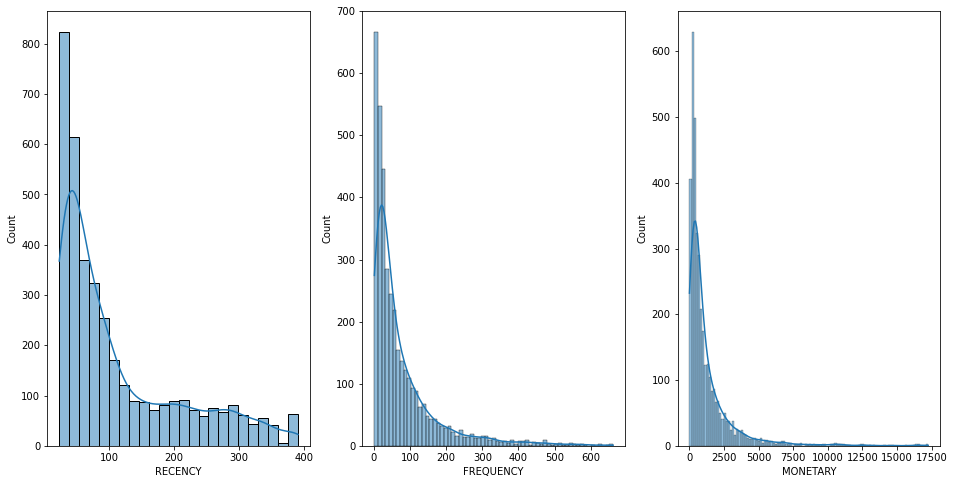

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

df_pd = df_tf.select("CUSTOMERID", "FREQUENCY", "RECENCY", "MONETARY").toPandas()

# Recency distribution plot
sns.histplot(df_pd['RECENCY'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(df_pd['FREQUENCY'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(df_pd['MONETARY'], kde=True, ax=ax[2])


## Use K-Means clustering to segment your customers based on RFM as features. For this, create a stored procedure to perform training directly on Snowflake without moving data out.
### 1. Write the implementation code of the stored proc

In [34]:
# Implementation code for the stored procedure
def kmeans_cluster (session: Session, max_iter: int, iterate: int) -> str:
        
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans


    scaler = StandardScaler()
    scaler.fit(df_pd[["FREQUENCY", "RECENCY", "MONETARY"]])
    print(scaler.mean_)
    df_train = scaler.transform(df_pd[["FREQUENCY", "RECENCY", "MONETARY"]])
    print (df_train)
    inertia = []
    results = []
    
    #sdf = session.createDataFrame(pdf_rules)
    #sdf.write.saveAsTable(to_table,mode="overwrite")


    if iterate==1:
        K = range(2,max_iter)
        for k in K:
            model = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(df_train)
            inertia.append(model.inertia_)
            results = inertia
    else:
        df_pd['Cluster'] = KMeans(n_clusters=max_iter, init='k-means++', random_state=42).fit(df_train).labels_
        df_output = session.createDataFrame(df_pd)
        df_output.write.saveAsTable("RFM_Clusters",mode="overwrite")
        results = "MODEL CREATED"
        
    return results


### 2. Register the stored proc in Snowflake

In [35]:
from snowflake.snowpark.functions import sproc

# This adds the necessary packages to our Python environment in Snowflake
# session.clear_packages()
session.add_packages("snowflake-snowpark-python","pandas","scikit-learn")

# We need a stage to host the stored proc
_ = session.sql('CREATE STAGE IF NOT EXISTS MODELS').collect()

# Register the stored proc
session.sproc.register(kmeans_cluster, name="kmeans_cluster", is_permanent=True, stage_location="@models", replace=True)


### 3. Finally, call the stored proc to perform K-Means


In [36]:
max_iter = 12
results = session.call("kmeans_cluster", max_iter, 1)


In [37]:
inertia = np.array(results[1:-1].split(',')).astype(float)

### Let's look at the elbow chart

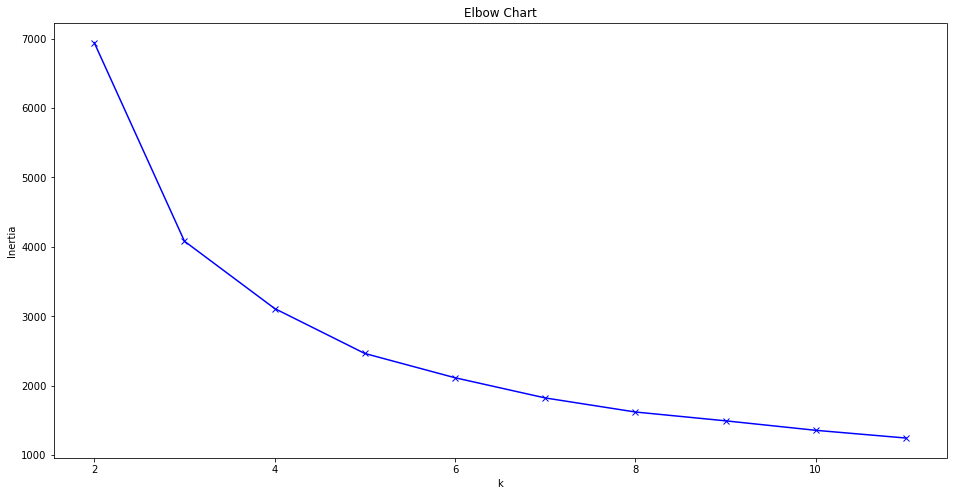

In [38]:
import matplotlib.pyplot as plt

K = range(2,max_iter)
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Chart')
plt.show()

### Elbow is around k=4

In [39]:
max_iter = 4
results = session.call("kmeans_cluster", max_iter, 0)

## Look at the results here https://customer-segmentation-snowpark.streamlit.app/